## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [7]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [9]:
# Opening JSON file 
# Write the path to your data file and load it 
f=open('complaints.json','r')  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [10]:
# Inspect the dataframe to understand the given data.
pd.set_option('display.max_columns', 60)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

- _source.date_sent_to_company,_id are not in proper dtype. 
- Many of the columns has missing value.

In [11]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [12]:
#Assign new column names
df.columns = ["index","type","id","score","tags","zip_code","complaint_id","issue","date_received","state","consumer_disputed","product","company_response","company","submitted_via","date_sent_to_company","company_public_response","sub_product","timely","complaint_what_happened","sub_issue","consumer_consent_provided"]
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [13]:
## Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']=='']=np.nan

In [14]:
#Remove all rows where complaints column is nan
df=df.dropna(subset=['complaint_what_happened'])
df.head(25)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
15,complaint-public-v2,complaint,3209411,0.0,None,None,3209411,Improper use of your report,2019-04-11T12:00:00-05:00,LA,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-11T12:00:00-05:00,None,Credit reporting,Yes,Can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided
17,complaint-public-v2,complaint,3331023,0.0,None,770XX,3331023,Closing an account,2019-08-06T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-06T12:00:00-05:00,None,Checking account,Yes,With out notice J.P. Morgan Chase restricted m...,Funds not received from closed account,Consent provided
20,complaint-public-v2,complaint,3352857,0.0,None,207XX,3352857,Struggling to pay your loan,2019-08-24T12:00:00-05:00,MD,N/A,Vehicle loan or lease,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-24T12:00:00-05:00,None,Loan,Yes,"During the summer months, I experience a decli...",Denied request to lower payments,Consent provided
21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,Fraud or scam,2019-04-29T12:00:00-05:00,UT,N/A,"Money transfer, virtual currency, or money ser...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-29T12:00:00-05:00,None,Domestic (US) money transfer,Yes,"On XXXX XX/XX/2019, I made a {$300.00} payment...",None,Consent provided
23,complaint-public-v2,complaint,3237765,0.0,None,330XX,3237765,Incorrect information on your report,2019-05-09T12:00:00-05:00,FL,N/A,Credit card or prepaid card,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2019-05-09T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have a Chase credit card which is incorrectl...,Account information incorrect,Consent provided


In [15]:
## See the first five customer complaints
for complains in df['complaint_what_happened'][:5]:
    print(complains)
    print('=='*60)

Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. 
In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. 
I have a right to know this information as a consumer. 

Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.
Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do

In [16]:
## See the last five customer complaints
for complains in df['complaint_what_happened'][:-6:-1]:
    print(complains)
    print('=='*60)

Roughly 10+ years ago I closed out my accounts with JP Morgan Chase Bank XXXX in order to close out an unsecured line of credit I had to pay it off. I did that to close out my account roughly {$500.00} payment when I closed out the accounts, and now I get this late payment that showed up on my credit report after 10+ years stating I owe close to {$900.00} dollars. I have never had any payment schedules or notifications in the 10+ years because I paid it off. Upon calling them I am told I need to show proof I paid it off. I would like to think that if indeed I had not paid it off ( which I did ) I would have immediately received late payment notifications. I left Chase bank because of some poor customer service and charges that were way out of line with the other banking institutions.
I have had flawless credit for 30 yrs. I've had Chase credit cards, " Chase Freedom '' specifically since XXXX with no problems ever. I've done many balance transfers in my life, so I have plenty of experi

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [17]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess_text(text):
    ## lowering the text
    text=text.lower()
    ##  removing the square brackets 
    text=re.sub('\[.*?\]','',text)
    ## removing special character from it ['!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    ## removing the number form it.
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text
df['clean_complaint_what_happened']=df['complaint_what_happened'].apply(lambda x:preprocess_text(x))
df.head(3)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,clean_complaint_what_happened
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...


In [18]:
## See the first five customer complaints
for complains in df['clean_complaint_what_happened'][:5]:
    print(complains)
    print('=='*60)

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services 
in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt 
i have a right to know this information as a consumer 

chase account  xxxx xxxx xxxx xxxx thanks in advance for your help
i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
chase card was reported on  however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the i

In [19]:
df=df[['complaint_what_happened','clean_complaint_what_happened']]

In [20]:
#Write your function to Lemmatize the texts
def lemmatizer(text):
    sent=[]
    ## taking the pre trained model en_core_web_sm.load() which do a word tokenize ,remove exta space,pos,lemma.
    doc=nlp(text)
    for word in doc:
       sent.append(word.lemma_)
        
    
    return ' '.join(sent)


In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['lemma_complaint_what_happened']=df.apply(lambda x: lemmatizer(x['clean_complaint_what_happened']), axis=1)

In [22]:
df_clean=df
df_clean.head()

,complaint_what_happened,clean_complaint_what_happened,lemma_complaint_what_happened
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [23]:
#Write your function to extract the POS tags 
from textblob import TextBlob
def pos_tag(text):
  # write your code here
    blog=TextBlob(text)
    ## extract out the word which are nouns
    pos=[word for (word,tag) in blog.tags if tag=='NN']
    return ' '.join(pos)
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"]
df_clean["complaint_POS_removed"]=df_clean.apply(lambda x:pos_tag(x['lemma_complaint_what_happened']),axis=1)


In [24]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,clean_complaint_what_happened,lemma_complaint_what_happened,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [25]:
# Write your code here to visualise the data according to the 'Complaint' character length
characher_length=[len(i) for i in df_clean['complaint_POS_removed']]
fig=px.histogram(characher_length,nbins=50,labels={'value':'Complaint Character length'},text_auto=True,title='Distrubtion of Complaint Character Length')
fig.show()

## ## In terms of the distribution of the word counts, it’s skewed a little positive but overall it’s a pretty normal distribution

## Around `15k` complaints are ranges between the compalint character length of 0-499. 

In [26]:
## getting all the words in the list
words=[]
for complains in df_clean['complaint_POS_removed']:
    for word in complains.lower().split():
                words.append(word)      


#### Find the top 40 words by frequency among all the articles after processing the text.

In [27]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from collections import Counter
counter=Counter
most_common_df=pd.DataFrame(Counter(words).most_common(25),columns=['Word','Counts'])    
most_common_df.style.background_gradient(cmap='viridis')

,Word,Counts
0,account,47488
1,chase,46549
2,xxxx,36539
3,credit,34141
4,card,29274
5,bank,28400
6,payment,21167
7,time,16022
8,charge,14992
9,check,13156


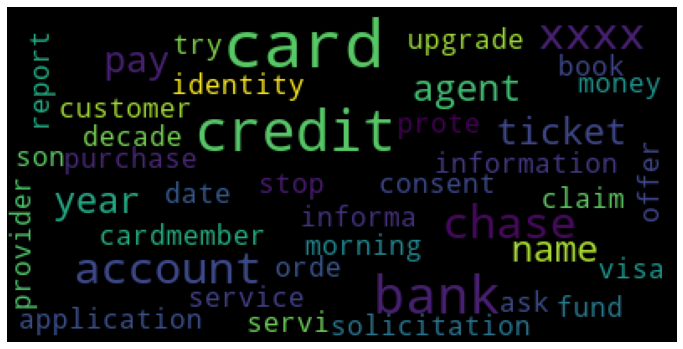

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  



stopword=set(stopwords.words('english'))

wordcloud = WordCloud(background_color='black',stopwords=stopword, max_words=40,max_font_size=40,  random_state=42 ).generate(str(df_clean['complaint_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [29]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [30]:
df_clean

,complaint_what_happened,clean_complaint_what_happened,lemma_complaint_what_happened,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom xxxx prob...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
## intializing the object of CounterVectorizer with Unigram
vect=CountVectorizer(stop_words='english')
## fit the data
bow=vect.fit_transform(df['Complaint_clean']).toarray()
bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [32]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_unigram(bow,n):
    df1=pd.DataFrame(bow,columns=vect.get_feature_names())
    col=df1.columns
    d={}
    for i in col:
        d[i]=sum(df1[i])
    import operator
    sorted_d=dict( sorted(d.items(), key=operator.itemgetter(1),reverse=True))
    Top_unigram=pd.DataFrame({'Word':sorted_d.keys(),'Frequency':sorted_d.values()}) 
    top_30=Top_unigram[:30]
    fig=px.bar(data_frame=top_30,x='Word',y='Frequency',title='Top 30 Unigrams',color='Word')
    fig.show()
    return Top_unigram[:n]

In [33]:
#Print the top 10 words in the unigram frequency
top_unigram(bow,10)

,Word,Frequency
0,account,47488
1,chase,46549
2,xxxx,36539
3,credit,34141
4,card,29274
5,bank,28401
6,payment,21167
7,time,16022
8,charge,14992
9,check,13156


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
## intializing the object of CounterVectorizer with bigram
vect=CountVectorizer(stop_words='english',ngram_range=(2,2))
## fit the data
bow=vect.fit_transform(df_clean['Complaint_clean'].values.astype('U'))
bow

<21072x311003 sparse matrix of type '<class 'numpy.int64'>'
	with 1069692 stored elements in Compressed Sparse Row format>

In [35]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [36]:
#Print the top 10 words in the bigram frequency
get_top_n_bigram(df_clean['Complaint_clean'],10)

[('credit card', 12777),
 ('credit report', 3947),
 ('xxxx xxxx', 3937),
 ('check account', 3146),
 ('customer service', 3081),
 ('chase credit', 2962),
 ('chase bank', 2938),
 ('bank account', 2728),
 ('account chase', 2579),
 ('account account', 2357)]

In [37]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['trigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 Trigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [38]:
#Print the top 10 words in the trigram frequency
get_top_n_trigram(df_clean['Complaint_clean'],10)

[('chase credit card', 2062),
 ('credit card account', 1018),
 ('credit card company', 991),
 ('credit card chase', 630),
 ('credit card credit', 514),
 ('inquiry credit report', 480),
 ('charge credit card', 423),
 ('xxxx xxxx xxxx', 409),
 ('account credit card', 398),
 ('card credit card', 386)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [39]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [40]:
#All masked texts has been removed
df_clean

,complaint_what_happened,clean_complaint_what_happened,lemma_complaint_what_happened,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call cha my xxxx xxxx ...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [41]:
#Write your code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_df=.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [42]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['Complaint_clean'])
dtm

<21072x7254 sparse matrix of type '<class 'numpy.float64'>'
	with 643523 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5
#keep the random_state =40
nmf_model = NMF(random_state=40,n_components=num_topics)

In [44]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7254

In [45]:
#Print the Top15 words for each of the topics
## getting the values of component[0]
single_topic=nmf_model.components_[0]
## sorting in ascending order and having index not a real value
single_topic.argsort()
## having the value which has highest value in component 0 and extracting last 15 from it.
top_word_indices=single_topic.argsort()[-15:]
## printing words
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

customer
transfer
claim
transaction
business
number
day
branch
deposit
chase
fund
money
bank
check
account


In [46]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')


THE TOP 15 WORDS FOR TOPIC #0
['customer', 'transfer', 'claim', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'purchase', 'claim', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




THE TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account'] -> __Banking Services__

THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit'] -> __Credit Card related Services__

THE TOP 15 WORDS FOR TOPIC #2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment'] -> __difficult to say__

THE TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge'] -> __Fraud and Dispute__

THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan'] -> __Mortgage and Loan Services__

In [47]:
topic_results = nmf_model.transform(dtm)
## for each compponets there is value is given one which has highest value that component assign to that.
topic_results

array([[0.0218948 , 0.01303003, 0.00660468, 0.0077185 , 0.02211197],
       [0.0087839 , 0.01477947, 0.00221235, 0.01193262, 0.00609131],
       [0.        , 0.06129756, 0.        , 0.        , 0.        ],
       ...,
       [0.01413527, 0.01463514, 0.        , 0.02333439, 0.00917546],
       [0.        , 0.04879597, 0.10215309, 0.01708015, 0.        ],
       [0.0316725 , 0.03217698, 0.09437317, 0.00441829, 0.00482268]])

In [48]:
## we are giving the component to that
## it takes a 1 rows at time and which has the highest value of that index 
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2], dtype=int64)

In [49]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [50]:
df_clean.head()

,complaint_what_happened,clean_complaint_what_happened,lemma_complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [51]:
#Print the first 5 Complaint for each of the Topics
df=df_clean.groupby('Topic').head(5)
df.sort_values('Topic').head()

,complaint_what_happened,clean_complaint_what_happened,lemma_complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,I opened an account with chase bank on XXXX an...,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
35,I opened the saving account for the {$25.00} b...,i opened the saving account for the bonus i w...,I open the saving account for the bonus I be...,account bonus bonus auto transfer check transf...,account bonus bonus auto transfer check transf...,0


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",1:"Credit card or prepaid card",2:"Others",3:"Theft/Dispute Reporting",4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic']=df_clean['Topic'].map(Topic_names)

In [53]:
df_clean.head()

,complaint_what_happened,clean_complaint_what_happened,lemma_complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Mortgage/Loan
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [54]:
#Create the dictionary again of Topic names and Topics
Topic_names = {"Bank Account services":0,"Credit card or prepaid card":1,"Others":2,"Theft/Dispute Reporting":3,"Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [55]:
df_clean.head(50)

,complaint_what_happened,clean_complaint_what_happened,lemma_complaint_what_happened,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
15,Can you please remove inquiry,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
20,"During the summer months, I experience a decli...",during the summer months i experience a declin...,during the summer month I experience a decline...,summer month income employment month payment e...,summer month income employment month payment e...,2
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,xxxx payment online retailer use pay xxxx chas...,payment online retailer use pay chase websit...,3
23,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [56]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [57]:
training_data['complaint_what_happened']

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [58]:

cvect=CountVectorizer()
#Write your code to get the Vector count
X_train_counts=cvect.fit_transform(training_data.complaint_what_happened)
X_train_counts
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tfidf=tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf

<21072x29725 sparse matrix of type '<class 'numpy.float64'>'
	with 2333942 stored elements in Compressed Sparse Row format>

In [59]:
## Creating x and y
y=training_data.pop('Topic')
X=X_train_tfidf
## spliting data into test and train set
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=.75,random_state=42)


## Model Building

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## LINEAR REGRESSION

In [60]:
## initializing the object of linear regression
lr=LogisticRegression()
## fit the data
model=lr.fit(X_train,y_train)
## predict on train data
y_train_pred=model.predict(X_train)
## predict on test data
y_test_pred=model.predict(X_test)

## Evaluation Metric

In [61]:
print(' train set')
print(accuracy_score(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_train,y_train_pred))
print(' test set')
print(accuracy_score(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

 train set
0.969944317894204
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3889
           1       0.97      0.97      0.97      3725
           2       0.98      0.93      0.96      1704
           3       0.96      0.96      0.96      3595
           4       0.97      0.98      0.98      2891

    accuracy                           0.97     15804
   macro avg       0.97      0.97      0.97     15804
weighted avg       0.97      0.97      0.97     15804

[[3826   16    1   39    7]
 [  22 3631    6   56   10]
 [  26   20 1588   38   32]
 [  58   45    9 3458   25]
 [  23   26   10    6 2826]]
 test set
0.9227410782080486
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1307
           1       0.93      0.93      0.93      1288
           2       0.95      0.87      0.91       555
           3       0.90      0.90      0.90      1205
           4       0.93      0.93      0.

## RANDOM FOREST

In [62]:
## initializing the object of Random forest
rfc=RandomForestClassifier()
## fit the data
model=rfc.fit(X_train,y_train)
## predict on train data
y_train_pred=model.predict(X_train)
## predict on test data
y_test_pred=model.predict(X_test)

## Evaluation Metric

In [63]:
print(' train set')
print(accuracy_score(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_train,y_train_pred))
print(' test set')
print(accuracy_score(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

 train set
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3889
           1       1.00      1.00      1.00      3725
           2       1.00      1.00      1.00      1704
           3       1.00      1.00      1.00      3595
           4       1.00      1.00      1.00      2891

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

[[3889    0    0    0    0]
 [   0 3725    0    0    0]
 [   0    0 1704    0    0]
 [   0    0    0 3595    0]
 [   0    0    0    0 2891]]
 test set
0.8215641609719059
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1307
           1       0.82      0.87      0.85      1288
           2       0.96      0.43      0.60       555
           3       0.81      0.82      0.82      1205
           4       0.85      0.87      0.86       913



## DECISION TREE

In [64]:
## initializing the object of Random forest
dt=DecisionTreeClassifier()
## fit the data
model=dt.fit(X_train,y_train)
## predict on train data
y_train_pred=model.predict(X_train)
## predict on test data
y_test_pred=model.predict(X_test)

## Evaluation Metric

In [65]:
print(' train set')
print(accuracy_score(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_train,y_train_pred))
print(' test set')
print(accuracy_score(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

 train set
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3889
           1       1.00      1.00      1.00      3725
           2       1.00      1.00      1.00      1704
           3       1.00      1.00      1.00      3595
           4       1.00      1.00      1.00      2891

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

[[3889    0    0    0    0]
 [   0 3725    0    0    0]
 [   0    0 1704    0    0]
 [   0    0    0 3595    0]
 [   0    0    0    0 2891]]
 test set
0.7775246772968869
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1307
           1       0.82      0.79      0.81      1288
           2       0.74      0.75      0.74       555
           3       0.73      0.74      0.73      1205
           4       0.78      0.81      0.79       913



## Checking For the Results

In [66]:
target_names = ["Bank Account services","Credit card or prepaid card","Others","Theft/Dispute Reporting","Mortgage/Loan"]
predicted = model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Others  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Theft/Dispute Reporting
Others  -  Theft/Dispute Reporting
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Bank Account services
Credit card or prepaid card  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Disp

Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Theft/Dispute Reporting
Others  -  Others
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Bank Account services  -  Mortgage/Loan
Mortgage/Loan  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Bank Account services
Theft/Dispute Reporting  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Others
Bank Account services  -  Others
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan 

Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Bank Account services  -  Mortgage/Loan
Others  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Others  -  Others
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/

Credit card or prepaid card  -  Credit card or prepaid card
Others  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Bank Account services  -  Bank Account services
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Credit card or prepaid card
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Others  -  Mortgage/Loan
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loa

Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Mortgage/Loan  -  Theft/Dispute Reporting
Mortgage/Loan  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Others  -  Others
Credit card or prepaid card  -  Theft/Dispute Reporting
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Others  -  Others
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Bank Account services
Bank A

Mortgage/Loan  -  Others
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Others  -  Others
Others  -  Others
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Bank Account services
Credit card or prepaid card  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Mortgage/Loan
Credit card or prepaid card  -  Credit card or prepaid card
Credit card or prepaid card  -  Credit card or prepaid card
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Others  -  Bank Account services
Theft/Dispute Reporting  -  Credit card or prepaid card
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Bank Account services  -  Bank Account services
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Theft/Dispute Reporting  -  Theft/Dispute Reporting
Mortgage/Loan  -  Mortgage/Loan
Theft/Dispute Reporting  -  Theft/Dispute 

## Using Random Forest with Hyperparamter Tunning

In [67]:
params={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [68]:
rfc=RandomForestClassifier()
cv=StratifiedKFold(n_splits=5)
rscv=RandomizedSearchCV(estimator=rfc,param_distributions=params,scoring='accuracy',n_jobs=-1,verbose=True,return_train_score=True,cv=cv)

In [69]:
rscv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   return_train_score=True, scoring='accuracy', verbose=True)

In [70]:
rscv.best_score_

0.8311824690952629

In [71]:
Result=pd.DataFrame(rscv.cv_results_)

In [72]:
col=['param_n_estimators','param_min_samples_split','param_min_samples_leaf','param_max_features','param_max_depth','param_bootstrap','mean_test_score','mean_train_score']

In [73]:
Result=Result[col].sort_values('mean_test_score',ascending=False)
Result.head()

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,mean_train_score
7,1200,2,2,auto,None,False,0.831182,0.997991
0,1400,10,2,sqrt,100,False,0.830992,0.997643
3,1000,2,2,auto,70,True,0.824855,0.991474
6,1800,10,4,sqrt,100,False,0.822007,0.977205
2,400,10,2,sqrt,None,True,0.821438,0.989401


## Using Linear Regression with Hyperparamter Tunning

In [74]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

# Create grid search object
lr=LogisticRegression()
clf = RandomizedSearchCV(lr, param_distributions= param_grid, cv =cv, verbose=True, n_jobs=-1,return_train_score=True,scoring='accuracy')

In [75]:
clf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     'none'],
                                         'solver': ['lbfgs', 'newton-cg',
                                                    'liblinear', 'sag',
                                                    'saga']}],
                   ret

In [76]:
clf.best_score_

0.9326754071576451

In [77]:
clf.best_params_

{'solver': 'liblinear',
 'penalty': 'l1',
 'max_iter': 5000,
 'C': 0.615848211066026}

In [78]:
result=pd.DataFrame(clf.cv_results_)
col=['param_solver','param_penalty','param_max_iter','param_C','mean_train_score','mean_test_score']
result=result[col].sort_values('mean_test_score',ascending=False)
result.head()

,param_solver,param_penalty,param_max_iter,param_C,mean_train_score,mean_test_score
2,liblinear,l1,5000,0.615848,0.940126,0.932675
8,saga,l1,100,545.559478,1.000000,0.917616
4,saga,l2,2500,0.615848,0.957479,0.911985
3,liblinear,l1,1000,0.033598,0.807517,0.805808
9,newton-cg,l2,100,0.000264,0.260219,0.260061


## Again Buliding Logistic Regression with best paramater using RandomSearchCV

In [79]:
## initializing the object of linear regression
lr=LogisticRegression(solver='saga', penalty='l1',max_iter=1000, C=11.288378916846883)
## fit the data
model=lr.fit(X_train,y_train)
## predict on train data
y_train_pred=model.predict(X_train)
## predict on test data
y_test_pred=model.predict(X_test)

## Evaluation Metric

In [80]:
print(' train set')
print(accuracy_score(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_train,y_train_pred))
print(' test set')
print(accuracy_score(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

 train set
0.9992406985573272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3889
           1       1.00      1.00      1.00      3725
           2       1.00      1.00      1.00      1704
           3       1.00      1.00      1.00      3595
           4       1.00      1.00      1.00      2891

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

[[3886    0    0    3    0]
 [   0 3722    0    3    0]
 [   0    0 1703    1    0]
 [   2    2    1 3590    0]
 [   0    0    0    0 2891]]
 test set
0.9320425208807896
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1307
           1       0.94      0.94      0.94      1288
           2       0.93      0.95      0.94       555
           3       0.92      0.90      0.91      1205
           4       0.93      0.94      0

In [267]:
## Creating the dict and storing the model ,tfidf transformer,countvectorizer
model={'countvect':cvect,'tifid':tfidf_transformer,'model':model}

In [268]:
import pickle

In [269]:
## save the model
filename='model.pkl'
pickle.dump(model, open(filename, 'wb'))

## Model Inference

## `Logistic Regression` work good  among all the models having `Accuracy` on `train set .9992` with `Precession and Recall 1` and having `Accuracy` on test set `.93` with `Precession(.93) and Recall(.94)` .